<a href="https://colab.research.google.com/github/aseelalzaben03/LSTM----BI-LSTM---ARAB-BERT-FAKE-NEWS-DETECTION-/blob/main/LSTM%2C_BI_LSTM_AND_BERT_ON_ARABIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code from here
#https://www.kaggle.com/code/shyakanobledavid/lstm-bi-lstm-and-bert-on-arabic

In [ ]:
import pandas as pd # Load data into a dataframe
import numpy as np
from sklearn.preprocessing import LabelEncoder # Used to fill Missing Values
from sklearn.model_selection import train_test_split # split data to train and test


In [ ]:

# TEXT PREPROCESSING
import nltk # Text Preprocessing
import re # Regular Expressions
from nltk.corpus import stopwords # Removes stop words from text
from snowballstemmer import stemmer# Word
from joblib import Parallel, delayed # Optimizes prepropcessing code

In [ ]:
# Model Construction
import tensorflow as tf
from tensorflow import keras # Build Neural Network
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizes text and creates sequences from them
from tensorflow.keras.preprocessing.sequence import pad_sequences # Adds padding to sequences
from transformers import BertTokenizer, TFBertModel
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # Model optimization
from tensorflow.keras.regularizers import l2 #Regularization
import joblib # Save model
from transformers import BertTokenizer, TFBertModel # Bert tokenizer and Model

In [ ]:



# Evaluation Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import class_weight

# Surpress warnings
import warnings

In [ ]:
#Surpress warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read data into a pandas dataframe
data=pd.read_csv("/content/balanced_data.csv")
data.head()

,Unnamed: 0,is_fake,news
0,0,1,قصة النافذة التي لا تُفتح إلا عندما يتوّج نابو...
1,1,1,سلطنة عمان لم تعلن إغلاق المجال الجويّ أمام طا...
2,2,0,"تنصح مجلة التكنولوجيا الألمانية ""سي.تي"" (c't) ..."
3,3,0,"كشفت شركة سامسونغ أخيرا عن مشروعها المنتظر ""ني..."
4,4,0,ودع باريس سان جيرمان الفرنسي بطولة دوري أبطال ...


In [ ]:
# check datasize
data.shape

(21720, 3)

In [ ]:
# check column names
data.columns

Index(['Unnamed: 0', 'is_fake', 'news'], dtype='object')

In [ ]:
# display statistiques on the data
data.describe()

,Unnamed: 0,is_fake
count,21720.000000,21720.000000
mean,10859.500000,0.500000
std,6270.168259,0.500012
min,0.000000,0.000000
25%,5429.750000,0.000000
50%,10859.500000,0.500000
75%,16289.250000,1.000000
max,21719.000000,1.000000


In [ ]:
data=data.drop(['Unnamed: 0'], axis=1)

In [ ]:
data.head()

,is_fake,news
0,1,قصة نافذ فتح عندم يتو نابول لقب دور حقيق
1,1,سلطن عمان تعل اغلاق مجال الجو طايرا حرب متجه يمن
2,0,تنصح مجل تكنولوجيا المان سي مستخدم ضرور تصفح م...
3,0,كشف شرك سامسونغ اخير مشروع منتظر نيون عبار روب...
4,0,ودع باريس سان جيرم فرنس طول دور ابطال اوروب لك...


In [ ]:
# check for columns with missing values
data.isnull().sum()

,0
is_fake,0
news,0


## Preprocessing

REMOVING NON-ARABIC CHARACTERS,CONVERTIG TO LOWERCASE, REMOVING STOP WORDS AND THEN STEMMING

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Initialize stopwords and stemmer
arabic_stopwords = set(stopwords.words('arabic'))
arabic_stemmer = stemmer('arabic')

def preprocess_article(article_content):
    # Remove non-Arabic characters
    article_content = re.sub('[^\u0621-\u064A\s]', ' ', article_content)

    # Lowercase and split into words
    article_content = article_content.lower().split()

    # Remove stopwords and stem the words
    article_content = [arabic_stemmer.stemWord(word) for word in article_content if word not in arabic_stopwords]

    # Join the words back into a single string
    return ' '.join(article_content)

# Apply preprocessing using parallel processing
processed_contents = Parallel(n_jobs=-1)(delayed(preprocess_article)(content) for content in data['news'])

# Update the DataFrame column with the processed content
data['news'] = processed_contents

In [ ]:
data.head()

,is_fake,news
0,1,قصة نافذ فتح عندم يتو نابول لقب دور حقيق
1,1,سلط عمان تعل اغلاق مجال الجو طاير حرب متج يمن
2,0,تنصح مجل تكنولوجي مان سي مستخدم ضرور تصفح ملف ...
3,0,كشف شرك سامسونغ اخير مشروع منتظر نيون عبار روب...
4,0,ودع باريس سان جيرم رنس طول دور ابطال اوروب لكر...


TOKENIZATION

In [ ]:
# Model Parameters
vocab_size = 20000
embedding_dim = 128
max_length=100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
num_epochs=5

In [ ]:
# Separate the dependent(target) variable from the independent variable
X = data['news'] # Select the 'news' column for features
y = data['is_fake'] # Select the 'is_fake' column for target


In [ ]:

X.shape,y.shape

((21720,), (21720,))

In [ ]:
# Split the data into train, validation and test splits
X_train,X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
#Test Y's shapes
y_train.shape , y_valid.shape


((13032,), (4344,))

In [ ]:
# Instanciate Tokenizer
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
# Fit tokenizer on training sentences
tokenizer.fit_on_texts(X_train.tolist())
#word_index=tokenizer.word_index

# Create training sequences
training_sequences=tokenizer.texts_to_sequences(X_train.tolist())
# Add padding to the sequences
training_to_padded=pad_sequences(training_sequences,maxlen=max_length, padding=padding_type,truncating=trunc_type)

# Create validation sequences
validation_sequences=tokenizer.texts_to_sequences(X_valid.tolist())
# Add padding to the sequences
validation_to_padded=pad_sequences(validation_sequences,maxlen=max_length, padding=padding_type,truncating=trunc_type)

# Create testing sequences
testing_sequences=tokenizer.texts_to_sequences(X_test.tolist())
# Add padding to the sequences
testing_to_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type,truncating=trunc_type)

In [ ]:
# check the if the sequencing and padding occured as expected
print(validation_to_padded[0])
validation_to_padded.shape

[ 547 1641 1013    4 1430 6354  647  114    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


(4344, 100)

## LSTM MODEL

LSTM MODEL CONSTRUCTION

In [ ]:
# Construct model using keras layers
model_lstm=tf.keras.Sequential(
    [
        # Embedding Layer
        tf.keras.layers.Embedding(vocab_size,embedding_dim),
        #tf.keras.layers.SpatialDropout1D(0.3),
        tf.keras.layers.LSTM(embedding_dim,recurrent_dropout=0.3),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(embedding_dim, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        # Dense Layer with Sigmoid Activation Function (Because this is a Binary classification, real or fake)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

In [ ]:
# LSTM Model Summary
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save the model
model_lstm.save('model_lstm_new.h5')

In [ ]:
# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch > 5:
        return lr * 0.5
    return lr

# Initial learning rate
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

LSTM TRAINING

In [ ]:
# Model training and validation
history=model_lstm.fit(training_to_padded,
                       np.array(y_train),
                       epochs=num_epochs,
                       batch_size=64,
                       validation_data=(validation_to_padded,np.array(y_valid)),
                       verbose=2 )

Epoch 1/5
204/204 - 75s - 366ms/step - accuracy: 0.9112 - loss: 0.2865 - val_accuracy: 0.9392 - val_loss: 0.2140
Epoch 2/5
204/204 - 66s - 323ms/step - accuracy: 0.9379 - loss: 0.1993 - val_accuracy: 0.9210 - val_loss: 0.2156
Epoch 3/5
204/204 - 66s - 322ms/step - accuracy: 0.9434 - loss: 0.1727 - val_accuracy: 0.9291 - val_loss: 0.2269
Epoch 4/5
204/204 - 66s - 324ms/step - accuracy: 0.9378 - loss: 0.1941 - val_accuracy: 0.9749 - val_loss: 0.0986
Epoch 5/5
204/204 - 83s - 407ms/step - accuracy: 0.9804 - loss: 0.0765 - val_accuracy: 0.9880 - val_loss: 0.0567


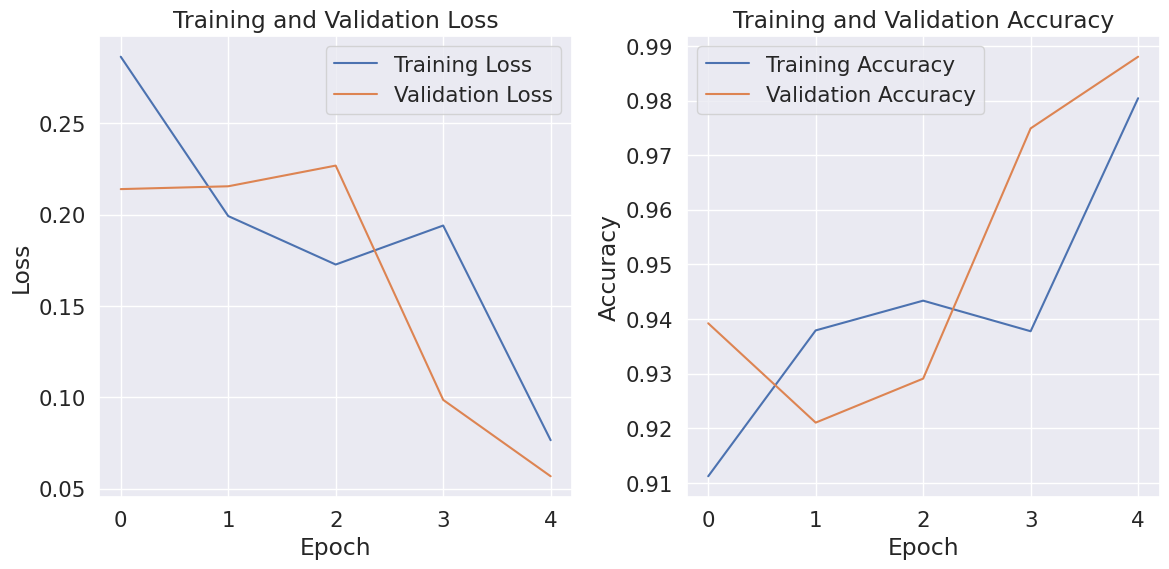

In [ ]:
# Plots training and validation loss and accuracy history for better analysis
def plot_history(history):
    # Get training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have trained your model and stored the history in a variable named 'history'
plot_history(history)

LSTM Testing

In [ ]:
# Make predicitons of the test data
lstm_predictions=model_lstm.predict(testing_to_padded)

136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


In [ ]:
# Round the predictions to the nearest integers (0 or 1)
lstm_predictions=lstm_predictions.round()

In [ ]:
lstm_predictions

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

LSTM MODEL EVALUATION METRICS

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1-score
precision = precision_score(y_test, lstm_predictions)
recall = recall_score(y_test, lstm_predictions)
f1 = f1_score(y_test, lstm_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9864549276039234
Recall: 0.9855342977134858
F1-score: 0.9859943977591037


BI-LSTM MODEL

In [ ]:
# Regularization parameter
l2_reg = 1e-2

# Construct model using keras layers
model_bilstm=tf.keras.Sequential(
    [
        # Embedding Layer
        tf.keras.layers.Embedding(vocab_size,embedding_dim),
        tf.keras.layers.Dropout(0.5),
        # Supperposed LSTM Layers to form a Bidirectional LSTM Layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,recurrent_dropout=0.5, kernel_regularizer=l2(l2_reg))),
        tf.keras.layers.Dropout(0.5),
        # Dense Layer with ReLU
        tf.keras.layers.Dense(embedding_dim, activation='relu', kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.Dropout(0.5),
        # Dense Layer with Sigmoid Activation Function (Because this is a Binary classification, real or fake)
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ]
)

In [ ]:
# Bi-LSTM Model Summary
model_bilstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save the model
model_bilstm.save('model_bilstm_new.h5')

In [ ]:
# Save model architecture to JSON
#model_json = model_bilstm.to_json()
#with open("model_bilstm.json", "w") as json_file:
 #   json_file.write(model_json)

# Save weights to HDF5
#model_bilstm.save_weights("model_bilstm_weights.weights.h5")

In [ ]:
# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch > 5:
        return lr * 0.5
    return lr

# Initial learning rate
learning_rate = 0.001

# set optimizer and pass the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Fixing Training Parameters
model_bilstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'] )

# # Early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Learning rate scheduler callback
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

BI-LSTM MODEL TRAINING

In [ ]:
# Model Trainning and Validation
history=model_bilstm.fit(training_to_padded,
                         np.array(y_train),
                         epochs=num_epochs,
                         batch_size=256,
                         validation_data=(validation_to_padded,np.array(y_valid)),
                         verbose=2)

Epoch 1/5
51/51 - 108s - 2s/step - accuracy: 0.8744 - loss: 3.4209 - val_accuracy: 0.9084 - val_loss: 1.4991
Epoch 2/5
51/51 - 139s - 3s/step - accuracy: 0.8898 - loss: 0.9794 - val_accuracy: 0.9065 - val_loss: 0.6020
Epoch 3/5
51/51 - 142s - 3s/step - accuracy: 0.8986 - loss: 0.5114 - val_accuracy: 0.9084 - val_loss: 0.4095
Epoch 4/5
51/51 - 142s - 3s/step - accuracy: 0.8893 - loss: 0.4383 - val_accuracy: 0.9075 - val_loss: 0.3772
Epoch 5/5
51/51 - 142s - 3s/step - accuracy: 0.7327 - loss: 0.6428 - val_accuracy: 0.9183 - val_loss: 0.5405


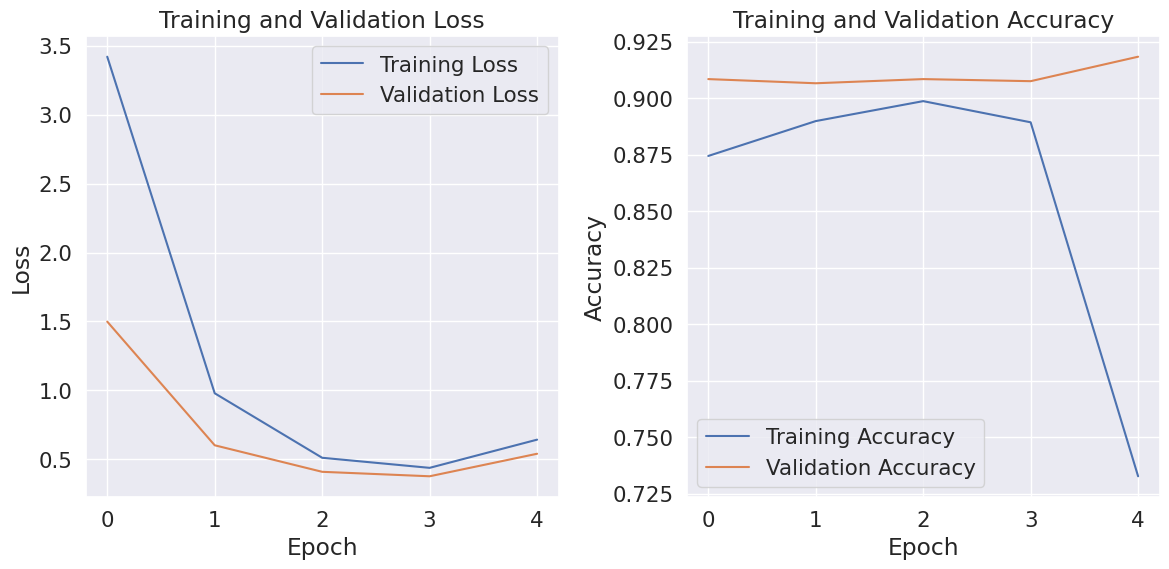

In [ ]:
# Plots training and validation loss and accuracy history for better analysis
def plot_history(history):
    # Get training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have trained your model and stored the history in a variable named 'history'
plot_history(history)

BI-LSTM MODEL TESTING

In [ ]:
bilstm_predictions=model_bilstm.predict(testing_to_padded)

136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step


In [ ]:
bilstm_predictions=bilstm_predictions.round()

In [ ]:
bilstm_predictions

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

BI-LSTM MODEL EVALUATION METRICS

In [ ]:
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, bilstm_predictions)
recall = recall_score(y_test, bilstm_predictions)
f1 = f1_score(y_test, bilstm_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8662179217501051
Recall: 0.9608026131591227
F1-score: 0.9110619469026549


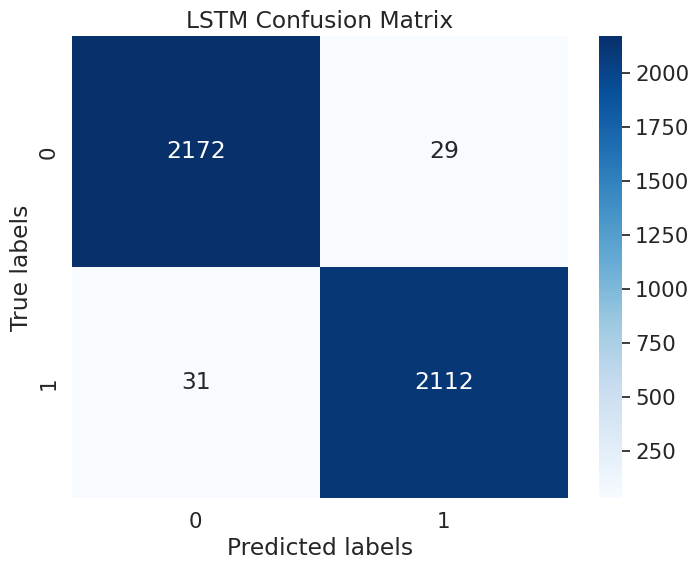

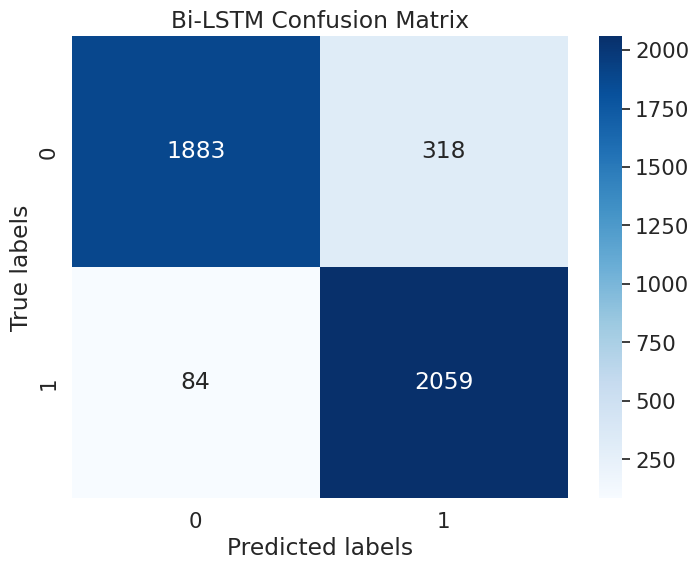

In [ ]:
# lstm confusion matrix
cm_lstm= confusion_matrix(y_test,lstm_predictions)
# bi-lstm confusion matrix
cm_bilstm= confusion_matrix(y_test,bilstm_predictions)

# Define labels for the matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['0', '1']


for i in [cm_lstm,cm_bilstm]:
    # Plot confusion matrix
    sns.set(font_scale=1.4) # for label size
    plt.figure(figsize=(8, 6))
    sns.heatmap(i, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    if i is cm_lstm:
        plt.title('LSTM Confusion Matrix')
        plt.show()
    else:
        plt.title('Bi-LSTM Confusion Matrix')
        plt.show()


In [ ]:
# Accuracy and Classification Report
for i in [lstm_predictions,bilstm_predictions]:
    if i is lstm_predictions:
        print("LSTM MODEL ACCURACY SCORE:\n")
        print(accuracy_score(y_test,i))
        print("\nLSTM CLASSIFICATION REPORT:\n")
        print(classification_report(y_test,i))
    else:
        print("Bi-LSTM MODEL ACCURACY SCORE:\n")
        print(accuracy_score(y_test,i))
        print("\nBi-LSTM CLASSIFICATION REPORT:\n")
        print(classification_report(y_test,i))


LSTM MODEL ACCURACY SCORE:

0.9861878453038674

LSTM CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2201
           1       0.99      0.99      0.99      2143

    accuracy                           0.99      4344
   macro avg       0.99      0.99      0.99      4344
weighted avg       0.99      0.99      0.99      4344

Bi-LSTM MODEL ACCURACY SCORE:

0.9074585635359116

Bi-LSTM CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      2201
           1       0.87      0.96      0.91      2143

    accuracy                           0.91      4344
   macro avg       0.91      0.91      0.91      4344
weighted avg       0.91      0.91      0.91      4344



## BERT MODEL

In [ ]:
# Tokenizing function for Bert model
def tokenize_texts(tokenizer, article, max_length=128):
    return tokenizer(
        article,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')
transformer_model = TFBertModel.from_pretrained('aubmindlab/bert-base-arabertv2')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

In [ ]:
# Tokenize train data X_train
tokenized_X_train = [tokenize_texts(tokenizer, article) for article in X_train]

# Tokenize validation data X_valid
tokenized_X_valid = [tokenize_texts(tokenizer, article) for article in X_valid]

# Tokenize test data X_test
tokenized_X_test = [tokenize_texts(tokenizer, article) for article in X_test]

In [ ]:
len(tokenized_X_train),len(tokenized_X_valid),len(tokenized_X_test)

(13032, 4344, 4344)

In [ ]:
#TRAINING DATA
# Getting the input id tensors from the tokenized list of input ids, token ids and attention mask
inputs_train=[i['input_ids'] for i in tokenized_X_train]

# Converting the input id tensors to numpy arrays
inputs_train_array = np.array([tensor.numpy() for tensor in inputs_train])

# Ensuring the shapes of inputs_array are compatible
inputs_train_array = inputs_train_array.squeeze(axis=1)

# Getting the attention_mask tensors from the tokenized list of input ids, token ids and attention mask
inputs_train_att=[i['attention_mask'] for i in tokenized_X_train]

# Converting the attention_mask tensors to numpy arrays
inputs_train_att_array = np.array([tensor.numpy() for tensor in inputs_train_att])

# Ensuring the shapes of inputs_array are compatible
inputs_train_att_array = inputs_train_att_array.squeeze(axis=1)

# VALIDATION DATA
# Getting the input id tensors from the tokenized list of input ids, token ids and attention mask
inputs_valid=[i['input_ids'] for i in tokenized_X_valid]

# Converting the input id tensors to numpy arrays
inputs_valid_array = np.array([tensor.numpy() for tensor in inputs_valid])

# Ensuring the shapes of inputs_array are compatible
inputs_valid_array = inputs_valid_array.squeeze(axis=1)

# Getting the attention_mask tensors from the tokenized list of input ids, token ids and attention mask
inputs_valid_att=[i['attention_mask'] for i in tokenized_X_valid]

# Converting the attention_mask tensors to numpy arrays
inputs_valid_att_array = np.array([tensor.numpy() for tensor in inputs_valid_att])

# Ensuring the shapes of inputs_array are compatible
inputs_valid_att_array = inputs_valid_att_array.squeeze(axis=1)

In [ ]:
# TESTING DATA
# Getting the input id tensors from the tokenized list of input ids, token ids and attention mask
inputs_test=[i['input_ids'] for i in tokenized_X_test]

# Converting the input id tensors to numpy arrays
inputs_test_array = np.array([tensor.numpy() for tensor in inputs_test])

# Ensuring the shapes of inputs_array are compatible
inputs_test_array = inputs_test_array.squeeze(axis=1)

# Getting the attention_mask tensors from the tokenized list of input ids, token ids and attention mask
inputs_test_att=[i['attention_mask'] for i in tokenized_X_test]

# Converting the attention_mask tensors to numpy arrays
inputs_test_att_array = np.array([tensor.numpy() for tensor in inputs_test_att])

# Ensuring the shapes of inputs_array are compatible
inputs_test_att_array = inputs_test_att_array.squeeze(axis=1)

ARABERT MODEL CONSTRUCTION¶

In [ ]:
# Model class
class CustomModel(tf.keras.Model):
    def __init__(self, transformer_model):
        super(CustomModel, self).__init__()
        self.transformer_model = transformer_model
        self.dense_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_ids, input_mask = inputs
        embedding = self.transformer_model(input_ids, attention_mask=input_mask)[0][:, 0, :]
        output = self.dense_layer(embedding)
        return output

In [ ]:
# Call build_model function which returns the model into model variable
model=CustomModel(transformer_model)

In [ ]:
# Initial learning rate
learning_rate = 0.001
# set optimizer and pass the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
y_train_np=np.array(y_train)
y_valid_np=np.array(y_valid)
y_test_np=np.array(y_test)

y_train_np.size,y_valid_np.size,y_test_np.size

(13032, 4344, 4344)

In [ ]:
# Train model
history=model.fit([inputs_train_array, inputs_train_att_array],
          y_train_np,
          epochs=5,
          batch_size=32,
          validation_data=([inputs_valid_array, inputs_valid_att_array],y_valid_np),
          verbose=2)

Epoch 1/5
408/408 - 7258s - 18s/step - accuracy: 0.9210 - loss: 0.2132 - val_accuracy: 0.9369 - val_loss: 0.1549
Epoch 2/5
408/408 - 7218s - 18s/step - accuracy: 0.9420 - loss: 0.1454 - val_accuracy: 0.9563 - val_loss: 0.1262
Epoch 3/5
408/408 - 7230s - 18s/step - accuracy: 0.9533 - loss: 0.1198 - val_accuracy: 0.9622 - val_loss: 0.1076
Epoch 4/5
408/408 - 7257s - 18s/step - accuracy: 0.9599 - loss: 0.1039 - val_accuracy: 0.9641 - val_loss: 0.0945
Epoch 5/5
408/408 - 7227s - 18s/step - accuracy: 0.9657 - loss: 0.0933 - val_accuracy: 0.9719 - val_loss: 0.0867


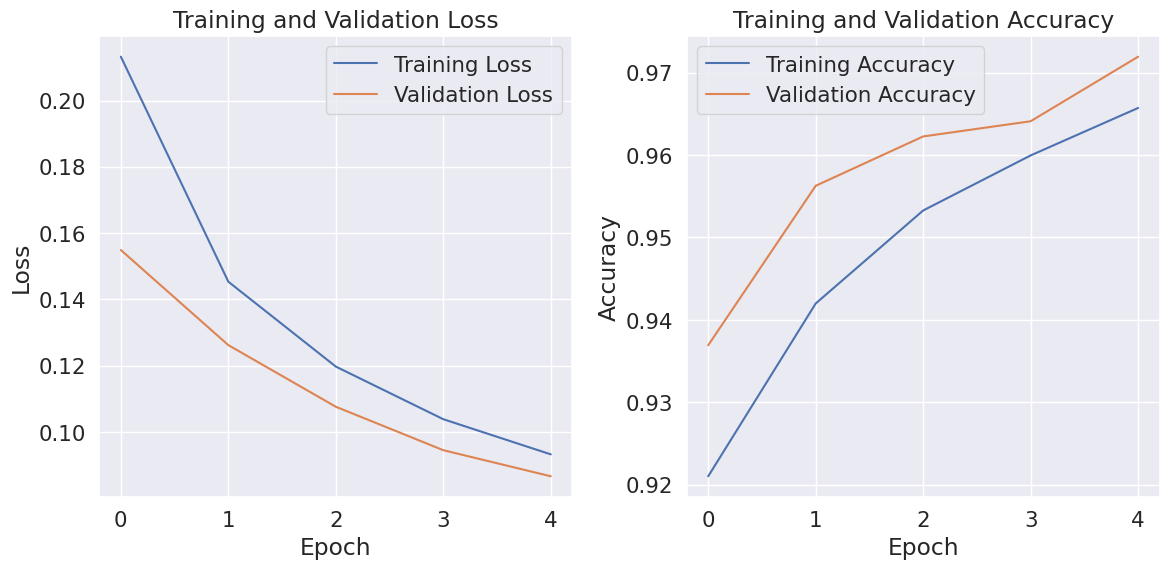

In [ ]:
# Plots training and validation loss and accuracy history for better analysis
def plot_history(history):
    # Get training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have trained your model and stored the history in a variable named 'history'
plot_history(history)

Arab BERT model Testing

In [ ]:
# Making Predicitons on the test data
arabert_predicitons=model.predict([inputs_test_array, inputs_test_att_array])

136/136 ━━━━━━━━━━━━━━━━━━━━ 1800s 13s/step


In [ ]:
# Round off predcitons to single intergers (0 or 1)
arabert_predicitons=arabert_predicitons.round()

ARABERT MODEL EVALUATION METRICS

In [ ]:
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, arabert_predicitons)
recall = recall_score(y_test, arabert_predicitons)
f1 = f1_score(y_test, arabert_predicitons)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9717779868297272
Recall: 0.9640690620625292
F1-score: 0.9679081752166784


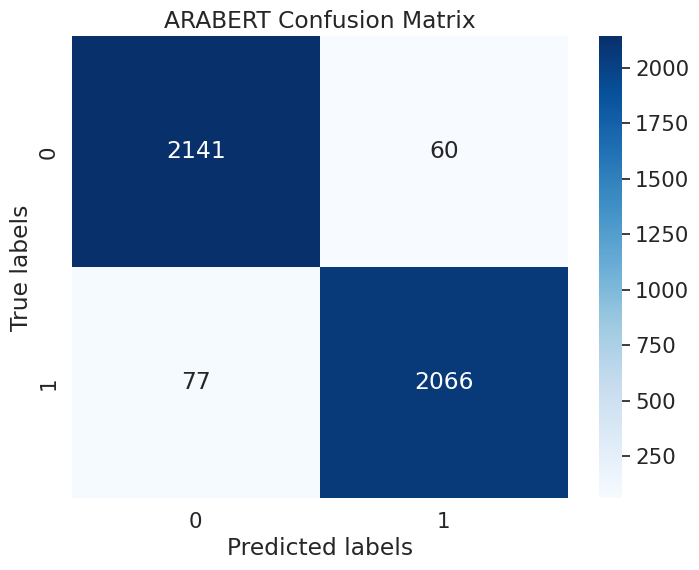

In [ ]:
# bert confusion matrix
cm_bert= confusion_matrix(y_test,arabert_predicitons)

# Define labels for the matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['0', '1']


# Plot confusion matrix
sns.set(font_scale=1.4) # for label size
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('ARABERT Confusion Matrix')
plt.show()

In [ ]:
# Accuracy and Classification Report
print("AraBert MODEL ACCURACY SCORE:\n")
print(accuracy_score(y_test,arabert_predicitons))
print("\nAraBert CLASSIFICATION REPORT:\n")
print(classification_report(y_test,arabert_predicitons))

AraBert MODEL ACCURACY SCORE:

0.9684622467771639

AraBert CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2201
           1       0.97      0.96      0.97      2143

    accuracy                           0.97      4344
   macro avg       0.97      0.97      0.97      4344
weighted avg       0.97      0.97      0.97      4344

